# Allen CCF

The Allen Common Coordinate Framework is a 3D atlas of the mouse brain [@10.1016/j.cell.2020.04.007].
It defines a coordinate system for the brain, with the origin at the anterior commissure and the x-axis pointing forward, the y-axis pointing left, and the z-axis pointing dorsal.

The Allen CCF provides a wealth of information about the brain structure, including the coordinates of the brain structures, the relationships between the brain structures, and the 3D coordinates of the brain structures.

This framework is translated into DataJoint as part of the DataJoint Elements Project Element Electrode Localization: https://github.com/datajoint/element-electrode-localization

In [3]:
pip install pynrrd

Note: you may need to restart the kernel to use updated packages.


In [4]:
%xmode minimal
import re
import datajoint as dj

schema = dj.Schema('allen_ccf')

log = dj.logger
import numpy as np
import pandas as pd
import tqdm
import pathlib
import nrrd

Exception reporting mode: Minimal


[2025-10-11 02:52:08,757][INFO]: DataJoint 0.14.6 connected to dev@db:3306


In [ ]:
@schema
class CCF(dj.Manual):

    definition = """  # Common Coordinate Framework
    ccf_id            : int             # CCF ID, a.k.a atlas ID
    ---
    ccf_version       : varchar(64)     # Allen CCF Version - e.g. CCFv3
    ccf_resolution    : float           # voxel resolution in micron
    ccf_description='': varchar(255)    # CCFLabel Description
    """

    class Voxel(dj.Part):

        definition = """  # CCF voxel coordinates
        -> master
        x   :  int   # (um)  Anterior-to-Posterior (AP axis)
        y   :  int   # (um)  Superior-to-Inferior (DV axis)
        z   :  int   # (um)  Left-to-Right (ML axis)
        index(y, z)
        """


@schema
class BrainRegionAnnotation(dj.Lookup):

    definition = """
    -> CCF
    """

    class BrainRegion(dj.Part):
        definition = """
        -> master
        acronym: varchar(32)
        ---
        region_name: varchar(128)
        region_id=null: int
        color_code="": varchar(6)  # Hex code of the color code of this region
        """

    class Voxel(dj.Part):
        definition = """
        -> master.BrainRegion
        -> CCF.Voxel
        """

    @classmethod
    def retrieve_acronym(self, acronym):
        """Retrieve the DataJoint translation of the CCF acronym"""
        return re.sub(r"(?<!^)(?=[A-Z])", "_", acronym).lower()

@schema
class ParentBrainRegion(dj.Lookup):
    definition = """
    # Hierarchical structure between the brain regions
    -> BrainRegionAnnotation.BrainRegion
    ---
    -> BrainRegionAnnotation.BrainRegion.proj(parent='acronym')
    """




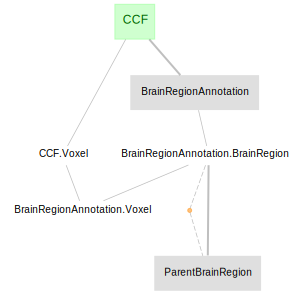

In [6]:
dj.Diagram(schema)

In [ ]:
def load_ccf_annotation(
    ccf_id, version_name, voxel_resolution, nrrd_filepath, ontology_csv_filepath
):
    """Load CCF annotation.

    For an example Allen brain atlas for mouse, see:
    http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017
    For the structure/ontology tree, see:
    https://community.brain-map.org/t/allen-mouse-ccf-accessing-and-using-related-data-and-tools/359
    (particularly the ontology file downloadable as CSV)

    Args:
        ccf_id (int): unique id to identify a new CCF dataset to be inserted.
        version_name (str): CCF version.
        voxel_resolution (float): voxel resolution in microns.
        nrrd_filepath (str): path to the .nrrd file for the volume data.
        ontology_csv_filepath (str): path to the .csv file for the brain region ontology.
    """
    ccf_key = {"ccf_id": ccf_id}
    if CCF & ccf_key:
        print(f"CCF ID {ccf_id} already exists!")
        return

    nrrd_filepath = pathlib.Path(nrrd_filepath)
    ontology_csv_filepath = pathlib.Path(ontology_csv_filepath)

    def to_snake_case(s):
        return re.sub(r"(?<!^)(?=[A-Z])", "_", s).lower()

    ontology = pd.read_csv(ontology_csv_filepath)

    stack, _ = nrrd.read(nrrd_filepath.as_posix())  # AP (x), DV (y), ML (z)

    log.info(
        ".. loaded atlas brain volume of shape " + f"{stack.shape} from {nrrd_filepath}"
    )

    ccf_key = {"ccf_id": ccf_id}
    ccf_entry = {
        **ccf_key,
        "ccf_version": version_name,
        "ccf_resolution": voxel_resolution,
        "ccf_description": (
            f"Version: {version_name}"
            + f" - Voxel resolution (uM): {voxel_resolution}"
            + f" - Volume file: {nrrd_filepath.name}"
            + " - Region ontology file: "
            + ontology_csv_filepath.name
        ),
    }

    with dj.conn().transaction:
        CCF.insert1(ccf_entry)
        BrainRegionAnnotation.insert1(ccf_key)
        BrainRegionAnnotation.BrainRegion.insert(
            [
                dict(
                    ccf_id=ccf_id,
                    acronym=to_snake_case(r.acronym),
                    region_id=r.id,
                    region_name=r.safe_name,
                    color_code=r.color_hex_triplet,
                )
                for _, r in ontology.iterrows()
            ]
        )

        # Process voxels per brain region
        for idx, (region_id, r) in enumerate(tqdm(ontology.iterrows())):
            dj.conn().ping()
            region_id = int(region_id)

            log.info(
                ".. loading region {} ({}/{}) ({})".format(
                    region_id, idx, len(ontology), r.safe_name
                )
            )

            # extracting filled volumes from stack in scaled [[x,y,z]] shape,
            vol = np.array(np.where(stack == region_id)).T * voxel_resolution
            vol = pd.DataFrame(vol, columns=["x", "y", "z"])

            if not vol.shape[0]:
                log.info(
                    ".. region {} volume: shape {} - skipping".format(
                        region_id, vol.shape
                    )
                )
                continue
            else:
                log.info(".. region {} volume: shape {}".format(region_id, vol.shape))

            vol["ccf_id"] = [ccf_key["ccf_id"]] * len(vol)
            CCF.Voxel.insert(vol)

            vol["acronym"] = [to_snake_case(r.acronym)] * len(vol)
            BrainRegionAnnotation.Voxel.insert(vol)

    log.info(".. done.")